In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
from multiprocess import Pool


import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [3]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"], "R": heat["R"]}

def calc_hc(st, T):

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

def calc_P(st, T):
    Z = mp.mpf(0)
    W = {}
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        W[e] = w
        Z += w
    for e in W:
        W[e] /= Z
    return W

In [90]:
#for D in tqdm([0.0, 0.5, 1.0, 1.5, 1.75, 1.8, 1.87,
#                        1.875, 1.9, 1.92, 1.9375, 1.95, 1.96,
#                        1.962, 1.963, 1.964, 1.965, 1.966, 1.967, 1.968, 1.96875, 1.969,
#                        1.97, 1.99,
#                        1.992]):
D = 1.9
L_list = [8, 12, 16, 20, 24, 30, 32, 40, 48, 50, 60, 64, 96]
#L_list = [64]
#x = [32]
cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
} for L in L_list], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
} for L in L_list]
print('D={}'.format(D))

parameters = []
for x in tqdm(zip(cool, heat)):
    try:
        parameters.append(read_tuple_files(x))
    except:
        pass
for i, x in tqdm(enumerate(parameters)):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))

D=1.9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()



L in 8, 12, 16, 20, 24, 32, 64


In [54]:
T_crit = {}
d = {}

In [ ]:
a = 0.4
b = 2.0

for x in tqdm(parameters):

    st = x["stitched"]
    L = st["L"]
    R = st["R"]
    t, c, _, _ = fminbound(lambda T: - calc_hc(st, T)[1], a, b, maxfun=500, full_output=1, disp=False)
    T_crit[L] = {
        "T_crit": float(t),
        "C_crit": float(-c / (L * L))
    }


In [94]:
T = 0.766

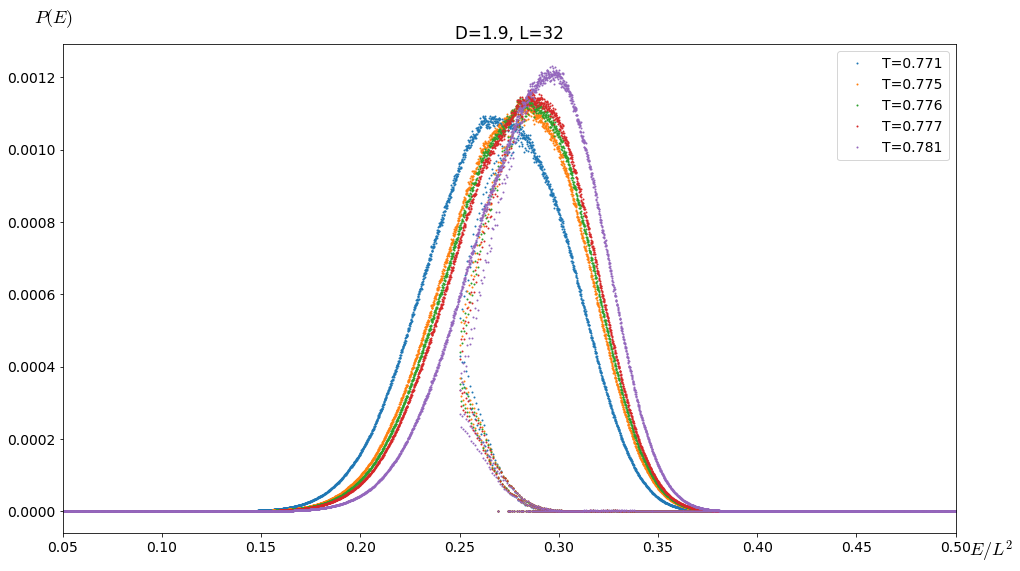

In [100]:

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([0.05, 0.5])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

for T in tqdm([T-0.005, T-0.001, T, T+0.001, T+0.005]):
    for x in parameters[-2:-1]:

        st = x["stitched"]
        L = st["L"]
        R = st["R"]
        if (D, L, R, T) not in d:
            d[(D, L, R, T)] = calc_P(st, T)
        P = d[(D, L, R, T)]

        ax.plot([E / (L * L) for E in P], [c for E, c in P.items()], 'o', markersize=1, label="T={}".format(T))
    
    #ax.set_ylim([0, 0.003])
    #ax.set_title("T={}".format(T_crit[L]['T_crit']), fontsize=18)
    #plt.yscale("log")
    #ax.legend()
    #plt.grid()
ax.set_title('D={}, L={}'.format(D, L))
ax.legend()
    #fig.savefig("./images/P(E)_D{}_L{}_R{}_T{}.png".format(D, L, R, "{0:07.6f}".format(T)), bbox_inches='tight')



In [96]:
T = 0.766

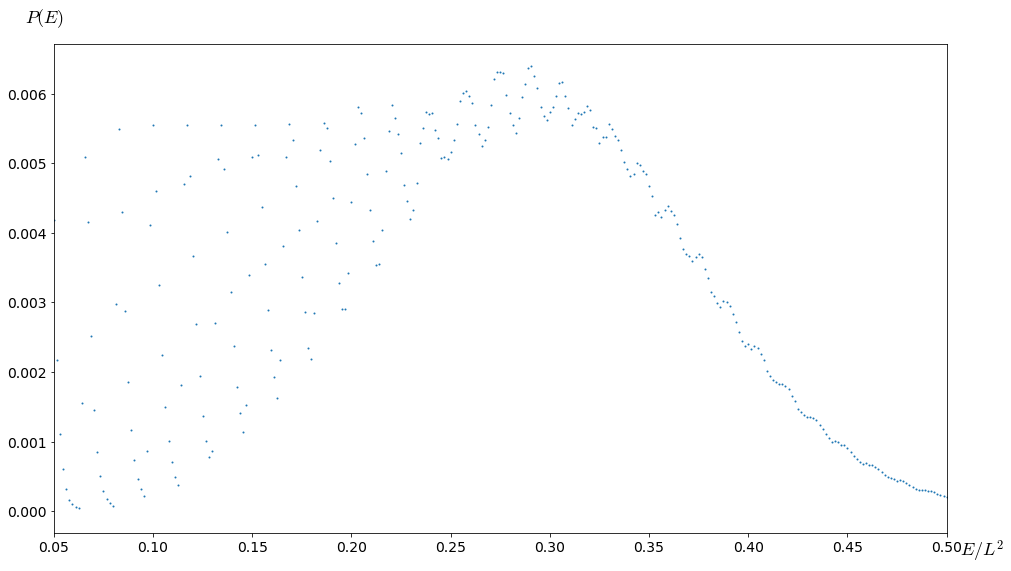

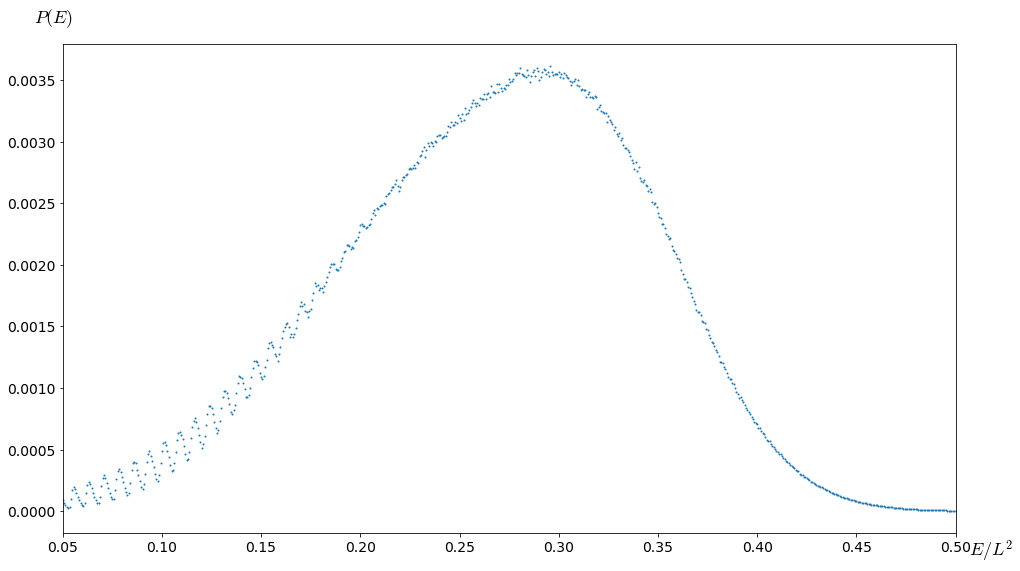

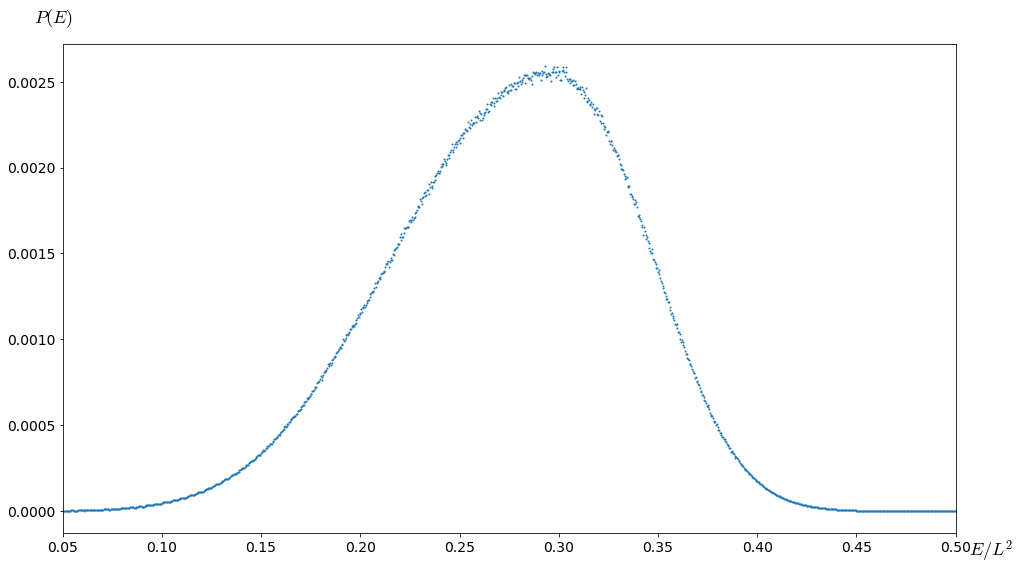

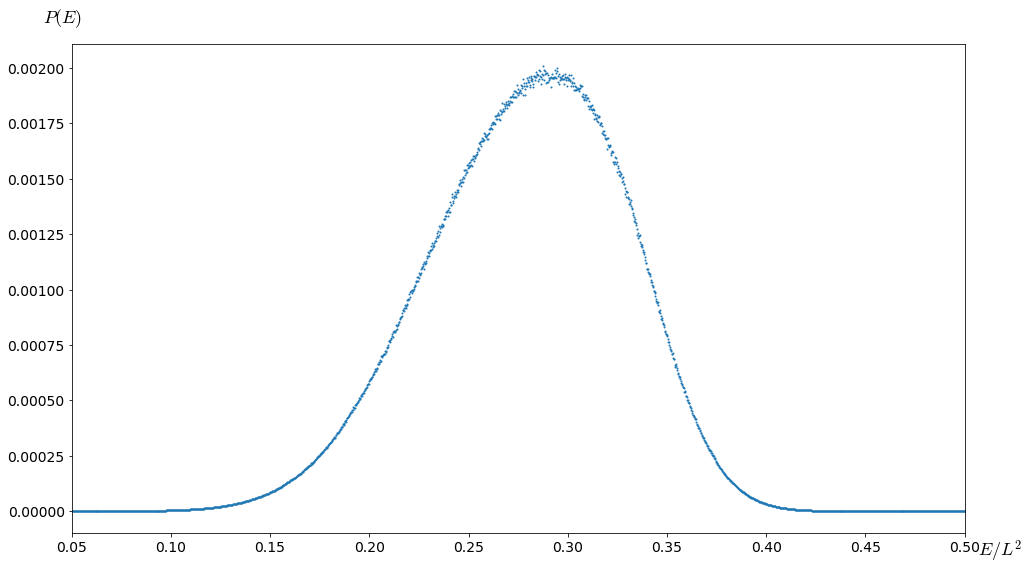

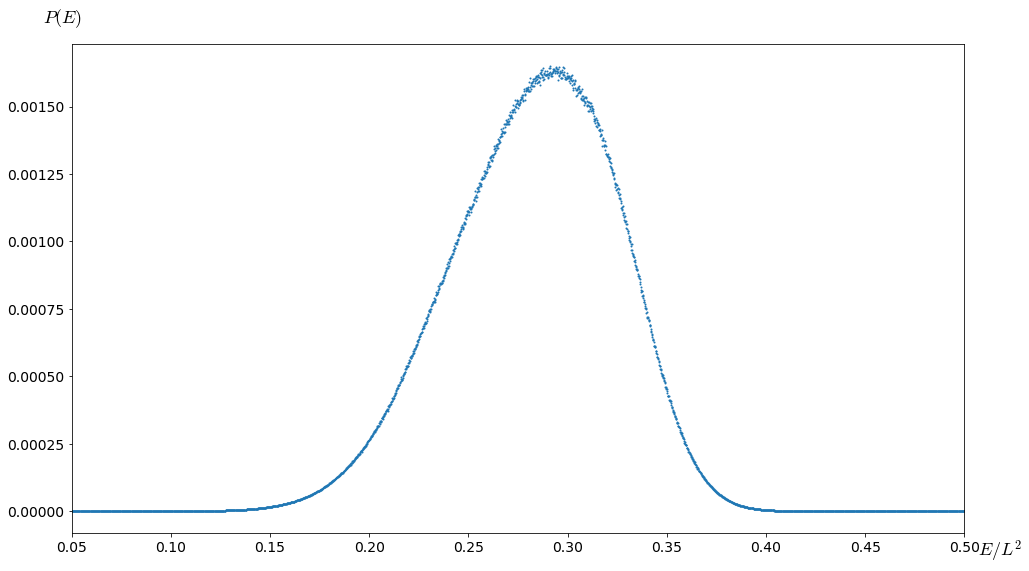

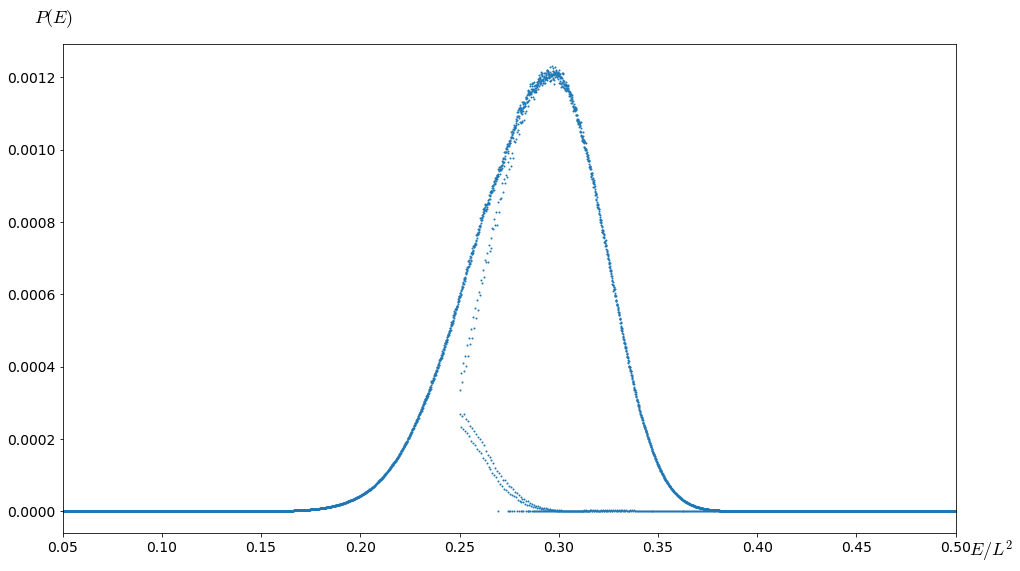

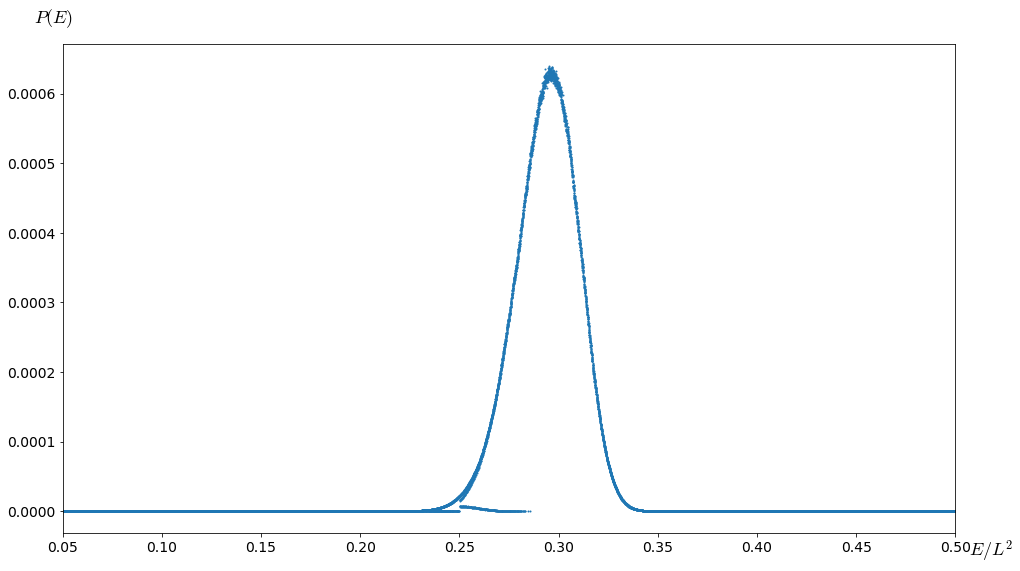

In [101]:

for x in tqdm(parameters):

    st = x["stitched"]
    L = st["L"]
    R = st["R"]
    if (D, L, R, T) not in d:
        d[(D, L, R, T)] = calc_P(st, T)
    P = d[(D, L, R, T)]

    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 9)
    ax.yaxis.set_label_coords(-0.01, 1.03)
    ax.xaxis.set_label_coords(1.04, -0.01)

    ax.plot([E / (L * L) for E in P], [c for E, c in P.items()], 'o', markersize=1)
    
    ax.set_xlim([0.05, 0.5])
    ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
    ax.set_xlabel("$E/L^2$", fontsize=18)
    #ax.set_title("T={}".format(T_crit[L]['T_crit']), fontsize=18)
    #plt.yscale("log")
    #ax.legend()
    #plt.grid()
    #plt.show()
    fig.savefig("./images/P(E)_D{}_L{}_R{}_T{}.png".format(D, L, R, "{0:07.6f}".format(T)), bbox_inches='tight')



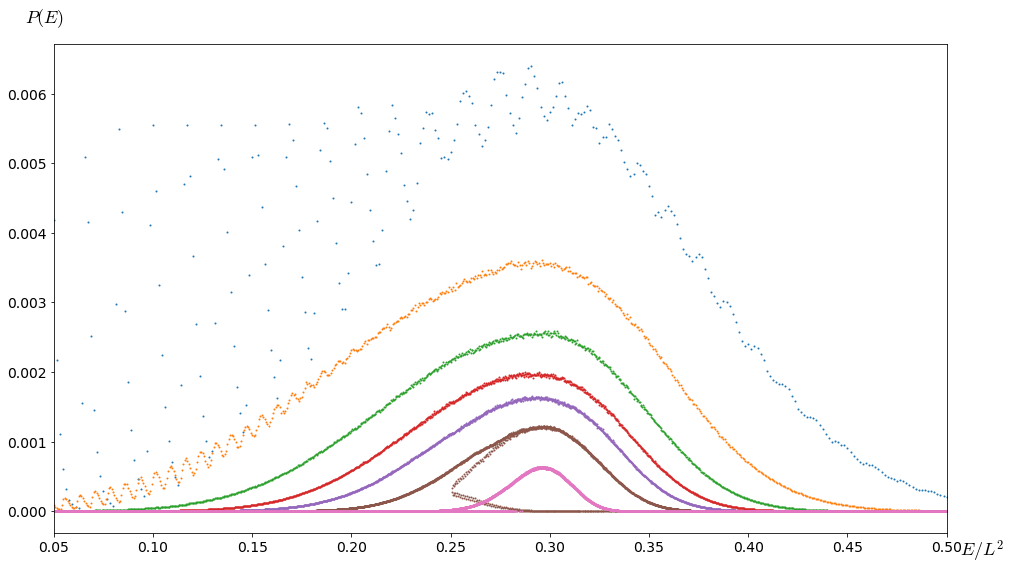

In [102]:
    
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

for x in tqdm(parameters):

    st = x["stitched"]
    L = st["L"]
    R = st["R"]
    if (D, L, R, T) not in d:
        d[(D, L, R, T)] = calc_P(st, T)
    P = d[(D, L, R, T)]

    
    ax.plot([E / (L * L) for E in P], [c for E, c in P.items()], 'o', markersize=1)
    
    #ax.set_ylim([0, 0.001])
    ax.set_xlim([0.05, 0.5])
    ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
    ax.set_xlabel("$E/L^2$", fontsize=18)
    #ax.set_title("T={}".format(T_crit[L]['T_crit']), fontsize=18)
    #plt.yscale("log")
    #ax.legend()
    #plt.grid()
    #plt.show()
fig.savefig("./images/P(E)_D{}_R{}_T{}.png".format(D, R, "{0:07.6f}".format(T)), bbox_inches='tight')



KeyboardInterrupt: 

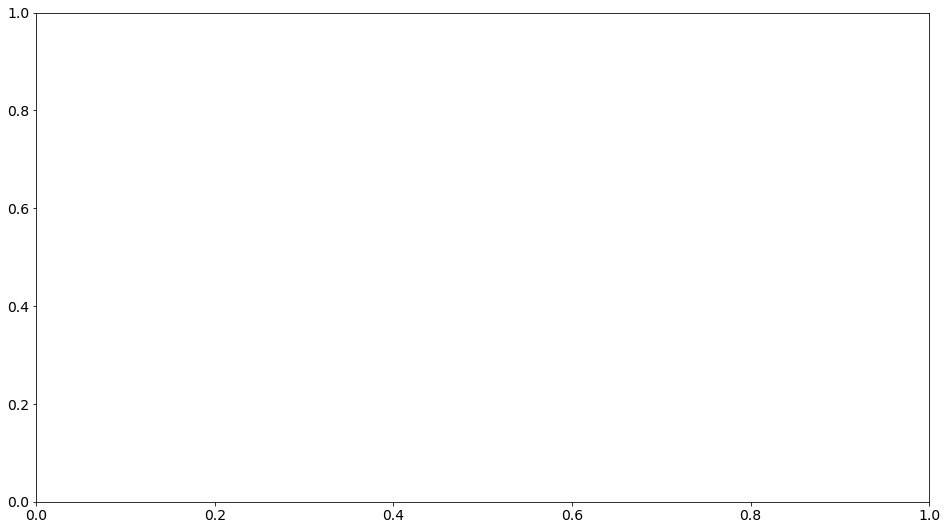

In [84]:
    
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

for x in tqdm(parameters[-1:]):

    st = x["stitched"]
    L = st["L"]
    R = st["R"]
    if (D, L, R, T) not in d:
        d[(D, L, R, T)] = calc_P(st, T)
    P = d[(D, L, R, T)]

    ax.plot([E / (L * L) for E in P], [c for E, c in P.items()], 'o', markersize=1)
    
    #ax.set_ylim([0, 0.005])
    #ax.set_xlim([0, 0.5])
    ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
    ax.set_xlabel("$E/L^2$", fontsize=18)
    #ax.set_title("T={}".format(T_crit[L]['T_crit']), fontsize=18)
    #plt.yscale("log")
    #ax.legend()
    #plt.grid()

plt.show()
#fig.savefig("./images/P(E)_D{}_R{}_T{}.png".format(D, R, "{0:07.6f}".format(T)), bbox_inches='tight')

